# Comparatifs de modèles
Les features présentées ne sont pas à jour avec la dernière version du main
## Imports

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

## Global variables and read data

In [49]:
# DATAPATH = "/kaggle/input/store-sales-time-series-forecasting"
DATAPATH = "data/store-sales"
FIGSIZE = (14, 4)

In [50]:
train_df = pd.read_csv(DATAPATH + '/train.csv',
                       usecols=['id', 'store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       dtype={
                           'id': 'uint32',
                           'store_nbr': 'int32',
                           'family': 'string',
                           'sales': 'float32',
                           'onpromotion': 'uint32',
                       },
                       parse_dates=['date'])

test_df = pd.read_csv(DATAPATH + '/test.csv',
                      dtype={
                          'id': 'uint32',
                          'store_nbr': 'int32',
                          'family': 'string',
                          'onpromotion': 'uint32',
                      },
                      parse_dates=['date'])

stores_df = pd.read_csv(DATAPATH + '/stores.csv',
                        dtype={
                            'store_nbr': 'int32',
                            'city': 'string',
                            'state': 'string',
                            'type': 'string',
                            'cluster': 'int32',
                        })

stores_df = stores_df.rename(columns={'type': 'store_type'})

transactions_df = pd.read_csv(DATAPATH + '/transactions.csv',
                              dtype={
                                  'store_nbr': 'int32',
                                  'transactions': 'uint32'
                              },
                              parse_dates=['date'])

oil_df = pd.read_csv(DATAPATH + '/oil.csv',
                     dtype={'dcoilwtico': 'float32'},
                     parse_dates=['date'])

holidays_df = pd.read_csv(DATAPATH + '/holidays_events.csv',
                          dtype={
                              'type': 'string',
                              'locale': 'string',
                              'locale_name': 'string',
                              'description': 'string',
                              'transferred': 'bool',
                          },
                          parse_dates=['date'])
holidays_df = holidays_df.rename(columns={'type': 'holiday_type'})


In [51]:
nb_outsamples = test_df['date'].nunique()
nb_stores = train_df['store_nbr'].nunique()
nb_families = train_df['family'].nunique()

## Features

In [52]:
def remove_outliers(df):
    val = df.sales.quantile(0.99)
    df = df.drop(df[df.sales > val].index)
    return df

# train_df = remove_outliers(train_df)

In [53]:
def assign_time_ft(df):
    dt_index = df['date'].dt

    df['day'] = dt_index.day
    df['payday'] = ((dt_index.day == 15) | dt_index.is_month_end).astype('int')
    df['dayofweek'] = dt_index.day_of_week.astype('int')
    df["dayofyear"] = dt_index.dayofyear
    df['weekday'] = dt_index.weekday
    df['month'] = dt_index.month
    df['month_end'] = dt_index.is_month_end.astype('int')

    df['year'] = dt_index.year
    df['newyear'] = df["dayofyear"] == 1

    df['startschool'] = dt_index.month.isin((4, 5, 8, 9))

    return df


train_df = assign_time_ft(train_df)
test_df = assign_time_ft(test_df)

In [54]:
def preprocess_oil(oil):
    oil['month'] = oil['date'].dt.month
    oil['month_avg'] = oil.groupby('month')['dcoilwtico'].transform('mean')

    oil['tmp'] = oil['dcoilwtico'].map(np.isnan)
    oil['month_avg'] = oil['tmp'] * oil['month_avg']
    oil['month_avg'] = oil['month_avg'].astype(float)

    oil['dcoilwtico'].fillna(0, inplace=True)
    oil['dcoilwtico'] = oil['dcoilwtico'] + oil['month_avg']

    oil = oil.drop(['month', 'month_avg', 'tmp'], axis=1)

    return oil


oil_df = preprocess_oil(oil_df)

In [55]:
def preprocess_holiday(df):
    filtered_holiday = df[(df['transferred'] == False) & (df['holiday_type'] != 'Work Day')]

    event = df[df['holiday_type'] == 'Event']
    earthquake = event[event['description'].str.startswith('Terremoto Manabi')]
    event = event[event['description'].str.startswith('Terremoto Manabi') == False]

    return filtered_holiday, event, earthquake


filtered_df, event_df, earthquake_df = preprocess_holiday(holidays_df)

In [56]:
event_df = event_df[['date', 'description']]
event_df.rename({'description': 'event_name'}, axis=1, inplace=True)

earthquake_df = earthquake_df[['date', 'description']]
earthquake_df.rename({'description': 'earthquake'}, axis=1, inplace=True)

In [57]:
h_local = filtered_df[filtered_df['locale'] == 'Local']
h_local = h_local[['date', 'locale_name', 'description']]
h_local = h_local.rename({'locale_name': 'city', 'description': 'local_hname'}, axis=1)

h_regional = filtered_df[filtered_df['locale'] == 'Regional']
h_regional = h_regional[['date', 'locale_name', 'description']]
h_regional = h_regional.rename({'locale_name': 'state', 'description': 'regional_hname'}, axis=1)

h_national = filtered_df[filtered_df['locale'] == 'National']
h_national = h_national[['date', 'description']]
h_national = h_national.rename({'description': 'national_hname'}, axis=1)

In [58]:
def merge_tables(df):
    df = df.merge(oil_df, on='date', how='left')
    df = df.merge(stores_df, on='store_nbr', how='left')

    df = df.merge(event_df, on='date', how='left')
    df = df.merge(earthquake_df, on='date', how='left')
    df = df.merge(h_local, on=['date', 'city'], how='left')
    df = df.merge(h_regional, on=['date', 'state'], how='left')
    df = df.merge(h_national, on='date', how='left')

    df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

    return df


train_df = merge_tables(train_df)
test_df = merge_tables(test_df)

In [59]:
del h_local, h_regional, h_national, earthquake_df, event_df, stores_df, oil_df, filtered_df, transactions_df

In [60]:
def handle_na(df):
    obj_vals = ['event_name', 'earthquake', 'local_hname', 'regional_hname', 'national_hname']
    df[obj_vals] = df[obj_vals].fillna('0')

    return df


train_df = handle_na(train_df)
test_df = handle_na(test_df)

In [61]:
encode_cols = ['family', 'store_nbr', 'store_type', 'event_name', 'earthquake', 'city', 'cluster', 'state',
               'local_hname', 'regional_hname', 'national_hname']

lb = LabelEncoder()

for c in encode_cols:
    train_df[c] = lb.fit_transform(train_df[c])
    test_df[c] = lb.transform(test_df[c])

del encode_cols, lb

In [62]:
def optimize_mem(df, for_int=False):
    gl_fl = df.select_dtypes(include=['float'])
    df[gl_fl.columns] = gl_fl.apply(pd.to_numeric, downcast="float")

    gl_int = df.select_dtypes(include=['int'])
    down_target = "integer" if for_int else "unsigned"

    df[gl_int.columns] = gl_int.apply(pd.to_numeric, downcast=down_target)

    return df

In [63]:
train_ids = train_df.id
test_ids = test_df.id

all_data = pd.concat([train_df, test_df]).reset_index()
all_data = optimize_mem(all_data)

In [64]:
def get_closed(df):
    df['isclosed'] = df.groupby(by=['date', 'store_nbr'])['sales'].transform(lambda x: 1 if x.sum() == 0 else 0)

    df.loc[((df['date'].dt.year == 2017) & (df['date'].dt.month == 8) & (df['date'].dt.day >= 16))
    , 'isclosed'] = df['isclosed'].apply(lambda x: 0)

    return df


all_data = get_closed(all_data)

In [65]:
df_zeros = all_data[all_data.isclosed == 1]
df_zeros = optimize_mem(df_zeros)

C:\Users\thoma\AppData\Local\Temp\ipykernel_11780\866086434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[gl_fl.columns] = gl_fl.apply(pd.to_numeric, downcast="float")
C:\Users\thoma\AppData\Local\Temp\ipykernel_11780\866086434.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[gl_int.columns] = gl_int.apply(pd.to_numeric, downcast=down_target)


In [66]:
def lag_ft(df, lag_limit):
    targets = ['sales', 'dcoilwtico', 'transactions']
    keys = ['store_nbr', 'family']

    lagres_df = pd.DataFrame()
    for target in targets:
        for lag in range(1, lag_limit + 1):
            lagres_df[target + '_lag_' + str(lag)] = df.groupby(keys)[target].shift(lag)

    return lagres_df


lag_df = lag_ft(all_data[['store_nbr', 'family', 'sales', 'dcoilwtico', 'transactions']], lag_limit=5)
all_data = all_data.join(lag_df)

In [67]:
all_data = all_data.drop_duplicates(subset=['id'], keep='first')
all_data = optimize_mem(all_data)

In [68]:
def create_rolling_ft(new_df):
    targets = ['sales', 'dcoilwtico']
    rollings = [3, 7, 14, 30]

    shift_df = pd.DataFrame()

    for target in targets:
        print(f'Creating {target} features')
        grouped = new_df.groupby(["store_nbr", "family"])[target]

        for rollval in rollings:
            results = {}

            avg_roll = grouped.rolling(rollval).mean()
            max_roll = grouped.rolling(rollval).max()
            min_roll = grouped.rolling(rollval).min()

            results[f"SMA{str(rollval)}_{target}_lag7_avg"] = avg_roll.shift(7).values
            results[f"SMA{str(rollval)}_{target}_lag7_max"] = max_roll.shift(7).values
            results[f"SMA{str(rollval)}_{target}_lag7_min"] = min_roll.shift(7).values

            results[f"SMA{str(rollval)}_{target}_lag30_avg"] = avg_roll.shift(30).values
            results[f"SMA{str(rollval)}_{target}_lag30_max"] = max_roll.shift(30).values
            results[f"SMA{str(rollval)}_{target}_lag30_min"] = min_roll.shift(30).values

            results[f"SMA{str(rollval)}_{target}_lag60_avg"] = avg_roll.shift(60).values
            results[f"SMA{str(rollval)}_{target}_lag60_max"] = max_roll.shift(60).values
            results[f"SMA{str(rollval)}_{target}_lag60_min"] = min_roll.shift(60).values

            result_df = pd.DataFrame.from_dict(results)
            shift_df = pd.concat([shift_df, result_df], axis=1)

        shift_df = optimize_mem(shift_df)

    return shift_df


print("Creating rolling features")
sort_df = all_data[["store_nbr", "family", "date", 'sales', 'dcoilwtico']].sort_values(["store_nbr", "family", "date"])
res_df = create_rolling_ft(sort_df)
all_data = all_data.join(res_df)
print('Out')

Creating rolling features
Creating sales features
Creating dcoilwtico features
Out


In [69]:
def create_smallrolling_ft(new_df):
    targets = ['transactions']
    rollings = [3, 7]

    shift_df = pd.DataFrame()

    for target in targets:
        print(f'Creating {target} features')
        grouped = new_df.groupby(["store_nbr", "family"])[target]

        for rollval in rollings:
            results = {}

            avg_roll = grouped.rolling(rollval).mean()
            max_roll = grouped.rolling(rollval).max()
            min_roll = grouped.rolling(rollval).min()

            results[f"SMA{str(rollval)}_{target}_lag7_avg"] = avg_roll.shift(7).values
            results[f"SMA{str(rollval)}_{target}_lag7_max"] = max_roll.shift(7).values
            results[f"SMA{str(rollval)}_{target}_lag7_min"] = min_roll.shift(7).values

            results[f"SMA{str(rollval)}_{target}_lag30_avg"] = avg_roll.shift(30).values
            results[f"SMA{str(rollval)}_{target}_lag30_max"] = max_roll.shift(30).values
            results[f"SMA{str(rollval)}_{target}_lag30_min"] = min_roll.shift(30).values

            results[f"SMA{str(rollval)}_{target}_lag60_avg"] = avg_roll.shift(60).values
            results[f"SMA{str(rollval)}_{target}_lag60_max"] = max_roll.shift(60).values
            results[f"SMA{str(rollval)}_{target}_lag60_min"] = min_roll.shift(60).values

            result_df = pd.DataFrame.from_dict(results)
            shift_df = pd.concat([shift_df, result_df], axis=1)

        shift_df = optimize_mem(shift_df)

    return shift_df


"""print("Creating small rolling features")
sort_df = all_data[["store_nbr", "family", "date",'transactions']].sort_values(["store_nbr", "family", "date"])
res_df = create_smallrolling_ft(sort_df)
all_data = all_data.join(res_df)
print('Out')"""

'print("Creating small rolling features")\nsort_df = all_data[["store_nbr", "family", "date",\'transactions\']].sort_values(["store_nbr", "family", "date"])\nres_df = create_smallrolling_ft(sort_df)\nall_data = all_data.join(res_df)\nprint(\'Out\')'

In [70]:
def create_exp_mov_av(df):
    targets = ['sales', 'dcoilwtico']
    span = [7, 16, 30, 60]

    ewm_df = pd.DataFrame()

    for target in targets:
        print(f'Creating {target} features')
        grouped = df.groupby(["store_nbr", "family"])[target]

        for sp in span:
            ewm_df[f'{target}_ewm_span_{sp}'] = grouped.ewm(span=sp).mean().values

        ewm_df = optimize_mem(ewm_df)

    return ewm_df


print("Creating ewm features")
res_df = create_exp_mov_av(all_data[["store_nbr", "family", 'sales', 'dcoilwtico']])
all_data = all_data.join(res_df)
print('Out')

Creating ewm features
Creating sales features
Creating dcoilwtico features
Out


In [71]:
del res_df, lag_df, sort_df

In [72]:
all_data = all_data.sort_values(['id'])
all_data = all_data.fillna(0)

In [73]:
all_data = optimize_mem(all_data, for_int=True)

In [74]:
def split_dfs(df):
    new_train = df[df['id'].isin(train_ids)]
    new_test = df[df['id'].isin(test_ids)]

    return new_train, new_test


train_df, test_df = split_dfs(all_data)

In [75]:
del all_data

## Training

In [76]:
xgb_params = {
    'n_estimators': 250,
    'importance_type': 'gain',
    'verbosity': 1,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'early_stopping_rounds': 30
}

In [89]:
def train_model_xgb(train, y):
    temp_train = train.copy()

    x_tr, x_v, y_tr, y_v = train_test_split(temp_train, y, train_size=split_size, random_state=42, shuffle=False)

    model = xgb.XGBRegressor(**xgb_params)
    trained_model = model.fit(x_tr, y_tr, eval_set=[(x_v, y_v)])

    return trained_model, x_v, y_v

In [90]:
from sklearn.linear_model import LinearRegression


def train_model_lreg(train, y):
    temp_train = train.copy()

    x_tr, x_v, y_tr, y_v = train_test_split(temp_train, y, train_size=split_size, random_state=42, shuffle=False)

    model = LinearRegression()
    trained_model = model.fit(x_tr, y_tr)

    return trained_model, x_v, y_v

In [91]:
from sklearn.linear_model import ElasticNet


def train_model_elas(train, y):
    temp_train = train.copy()

    x_tr, x_v, y_tr, y_v = train_test_split(temp_train, y, train_size=split_size, random_state=42, shuffle=False)

    model = ElasticNet()
    trained_model = model.fit(x_tr, y_tr)

    return trained_model, x_v, y_v, None

In [ ]:
from sklearn.ensemble import RandomForestRegressor


def train_model_rf(train, y):
    temp_train = train.copy()

    x_tr, x_v, y_tr, y_v = train_test_split(temp_train, y, train_size=split_size, random_state=42, shuffle=False)

    model = RandomForestRegressor(n_estimators=50)  # very slow
    trained_model = model.fit(x_tr, y_tr)

    return trained_model, x_v, y_v, None

In [92]:
split_size = 0.8
drop_cols = ['id', 'date', 'sales']
print("Starting training phase")

Starting training phase


In [93]:
def show_metrics(actual, predictions, mdict):
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions, squared=True)
    rmsle = mean_squared_log_error(actual, predictions)
    r2 = r2_score(actual, predictions)

    print("\nRegression metrics")
    print('MAE: {:.2f}'.format(mae))
    print('MSE: {:.2f}'.format(mse))
    print('RMSLE: {:.2f}'.format(rmsle))
    print('R2: {:.2f}'.format(r2))

    if mdict is not None:
        mdict["mae"].append(mae)
        mdict["mse"].append(mse)
        mdict["rmsle"].append(rmsle)
        mdict["r2"].append(r2)

In [94]:
%matplotlib inline

def plot_predictions(nb_samples, actual, predictions):
    sp_list = list(range(0, nb_samples))

    plt.figure(figsize=FIGSIZE)
    plt.subplot(1, 2, 1)
    plt.plot(sp_list, actual, label='Expected', alpha=0.5)
    plt.plot(sp_list, predictions, label='Predicted', alpha=0.5)
    plt.legend(loc="upper right")
    plt.title('Expected & Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Sales')

    plt.subplot(1, 2, 2)
    plt.plot(sp_list, abs(actual - predictions))
    plt.title('Difference (actual - preds)')
    plt.xlabel('Samples')
    plt.ylabel('Difference')

    plt.show()

In [95]:
def evalmodel(md, x_v, y_v):
    print(f"\nEvaluating model")
    y_pred = md.predict(x_v)
    y_pred[y_pred < 0] = 0

    show_metrics(y_v, y_pred, None)

    plot_predictions(len(x_v), y_v, y_pred)
    plt.show()

In [97]:
y_train = train_df['sales']
x_train = train_df.drop(drop_cols, axis=1)

In [98]:
test_model, x_val, y_val = train_model_xgb(x_train, y_train)

[0]	validation_0-rmse:1064.67984
[1]	validation_0-rmse:806.95903
[2]	validation_0-rmse:628.66338
[3]	validation_0-rmse:511.47326
[4]	validation_0-rmse:438.73098
[5]	validation_0-rmse:395.47394
[6]	validation_0-rmse:367.98809
[7]	validation_0-rmse:349.22127
[8]	validation_0-rmse:337.15696
[9]	validation_0-rmse:327.90870
[10]	validation_0-rmse:320.61838
[11]	validation_0-rmse:317.78213
[12]	validation_0-rmse:314.21127
[13]	validation_0-rmse:312.62439
[14]	validation_0-rmse:310.71523
[15]	validation_0-rmse:309.78453
[16]	validation_0-rmse:307.53142
[17]	validation_0-rmse:305.77818
[18]	validation_0-rmse:304.85764
[19]	validation_0-rmse:303.92504
[20]	validation_0-rmse:305.87128
[21]	validation_0-rmse:303.88594
[22]	validation_0-rmse:302.33044
[23]	validation_0-rmse:302.35606
[24]	validation_0-rmse:302.75095
[25]	validation_0-rmse:302.68152
[26]	validation_0-rmse:301.45243
[27]	validation_0-rmse:302.19695
[28]	validation_0-rmse:301.13228
[29]	validation_0-rmse:300.71110
[30]	validation_0-r


Evaluating model

Regression metrics
MAE: 69.04
MSE: 85264.08
RMSLE: 0.60
R2: 0.95


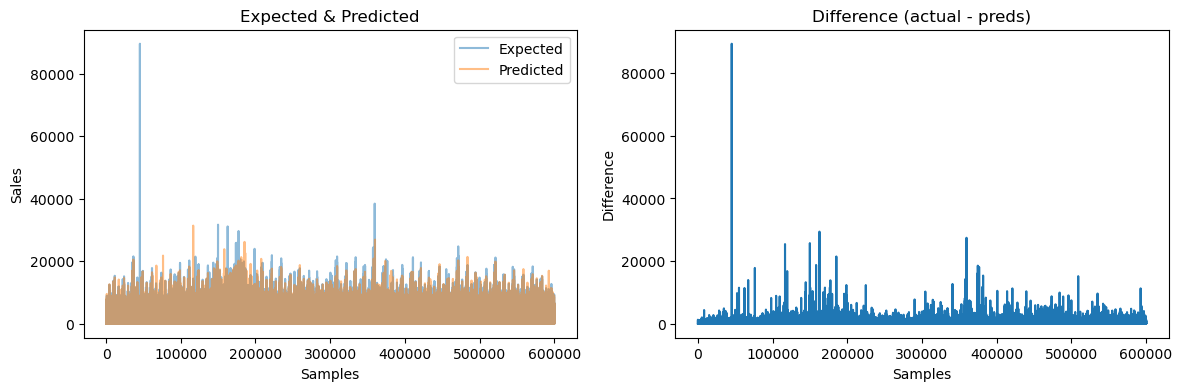

In [99]:
evalmodel(test_model, x_val, y_val)

In [101]:
test_model, x_val, y_val = train_model_lreg(x_train, y_train)


Evaluating model

Regression metrics
MAE: 131.24
MSE: 201141.43
RMSLE: 3.01
R2: 0.89


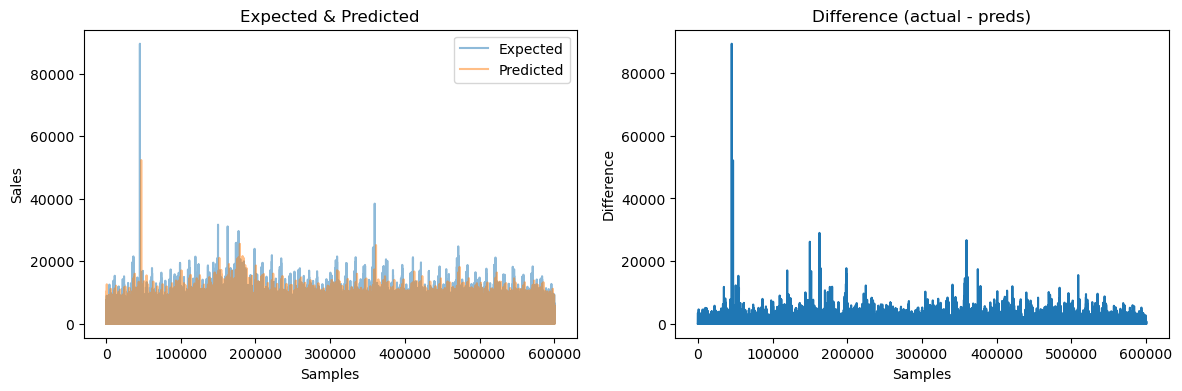

In [102]:
evalmodel(test_model, x_val, y_val)

In [103]:
test_model, x_val, y_val = train_model_elas(x_train, y_train)

C:\Dev\Anaconda\envs\timeseries\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.444e+10, tolerance: 2.521e+08
  model = cd_fast.enet_coordinate_descent(



Evaluating model

Regression metrics
MAE: 132.21
MSE: 201905.94
RMSLE: 2.90
R2: 0.89


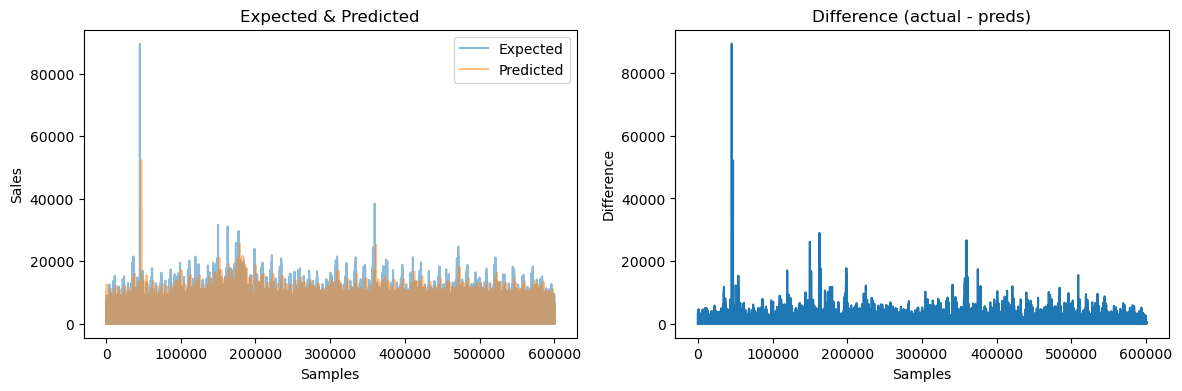

In [104]:
evalmodel(test_model, x_val, y_val)

In [ ]:
test_model, x_val, y_val = train_model_rf(x_train, y_train)

In [ ]:
evalmodel(test_model, x_val, y_val)

In [105]:
print('Notebook done')


Notebook done
